- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [12]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from googlenet_pytorch import GoogLeNet 


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [14]:
test = 2

In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [16]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy and Loss in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [18]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    #
    #googlenet, shufflenet, mobilenet 
    #

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "shufflenet":
        """ shufflenet
        """
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "mobilenet":
        """ mobilenet
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [21]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.5363 Acc: 0.8254
val Loss: 0.2465 Acc: 0.9435

Epoch 1/299
----------
train Loss: 0.3249 Acc: 0.8961
val Loss: 0.1863 Acc: 0.9531

Epoch 2/299
----------
train Loss: 0.2839 Acc: 0.9005
val Loss: 0.1614 Acc: 0.9543

Epoch 3/299
----------
train Loss: 0.2706 Acc: 0.9050
val Loss: 0.1470 Acc: 0.9572

Epoch 4/299
----------
train Loss: 0.2621 Acc: 0.9064
val Loss: 0.1392 Acc: 0.9572

Epoch 5/299
----------
train Loss: 0.2490 Acc: 0.9107
val Loss: 0.1370 Acc: 0.9560

Epoch 6/299
----------
train Loss: 0.2451 Acc: 0.9125
val Loss: 0.1306 Acc: 0.9564

Epoch 7/299
----------
train Loss: 0.2376 Acc: 0.9116
val Loss: 0.1272 Acc: 0.9601

Epoch 8/299
----------
train Loss: 0.2289 Acc: 0.9174
val Loss: 0.1212 Acc: 0.

train Loss: 0.1906 Acc: 0.9281
val Loss: 0.0874 Acc: 0.9705

Epoch 94/299
----------
train Loss: 0.1925 Acc: 0.9303
val Loss: 0.0899 Acc: 0.9685

Epoch 95/299
----------
train Loss: 0.1886 Acc: 0.9303
val Loss: 0.0886 Acc: 0.9697

Epoch 96/299
----------
train Loss: 0.1945 Acc: 0.9269
val Loss: 0.0832 Acc: 0.9714

Epoch 97/299
----------
train Loss: 0.1950 Acc: 0.9255
val Loss: 0.0890 Acc: 0.9689

Epoch 98/299
----------
train Loss: 0.1979 Acc: 0.9264
val Loss: 0.0906 Acc: 0.9660

Epoch 99/299
----------
train Loss: 0.1894 Acc: 0.9287
val Loss: 0.0879 Acc: 0.9705

Epoch 100/299
----------
train Loss: 0.1840 Acc: 0.9309
val Loss: 0.0889 Acc: 0.9697

Epoch 101/299
----------
train Loss: 0.1948 Acc: 0.9266
val Loss: 0.0851 Acc: 0.9705

Epoch 102/299
----------
train Loss: 0.1937 Acc: 0.9243
val Loss: 0.0897 Acc: 0.9689

Epoch 103/299
----------
train Loss: 0.1879 Acc: 0.9306
val Loss: 0.0901 Acc: 0.9705

Epoch 104/299
----------
train Loss: 0.1956 Acc: 0.9266
val Loss: 0.0844 Acc: 0.9701


val Loss: 0.0874 Acc: 0.9734

Epoch 189/299
----------
train Loss: 0.1965 Acc: 0.9249
val Loss: 0.0847 Acc: 0.9714

Epoch 190/299
----------
train Loss: 0.1915 Acc: 0.9263
val Loss: 0.0821 Acc: 0.9705

Epoch 191/299
----------
train Loss: 0.1820 Acc: 0.9329
val Loss: 0.0875 Acc: 0.9722

Epoch 192/299
----------
train Loss: 0.1828 Acc: 0.9321
val Loss: 0.0928 Acc: 0.9680

Epoch 193/299
----------
train Loss: 0.1916 Acc: 0.9285
val Loss: 0.0864 Acc: 0.9697

Epoch 194/299
----------
train Loss: 0.1846 Acc: 0.9303
val Loss: 0.0824 Acc: 0.9722

Epoch 195/299
----------
train Loss: 0.1859 Acc: 0.9301
val Loss: 0.0845 Acc: 0.9714

Epoch 196/299
----------
train Loss: 0.1871 Acc: 0.9290
val Loss: 0.0834 Acc: 0.9726

Epoch 197/299
----------
train Loss: 0.1904 Acc: 0.9289
val Loss: 0.0861 Acc: 0.9689

Epoch 198/299
----------
train Loss: 0.1959 Acc: 0.9259
val Loss: 0.0858 Acc: 0.9722

Epoch 199/299
----------
train Loss: 0.1802 Acc: 0.9323
val Loss: 0.0867 Acc: 0.9730

Epoch 200/299
----------

train Loss: 0.1953 Acc: 0.9262
val Loss: 0.0872 Acc: 0.9718

Epoch 285/299
----------
train Loss: 0.1871 Acc: 0.9294
val Loss: 0.0828 Acc: 0.9722

Epoch 286/299
----------
train Loss: 0.1918 Acc: 0.9294
val Loss: 0.0840 Acc: 0.9726

Epoch 287/299
----------
train Loss: 0.1845 Acc: 0.9328
val Loss: 0.0966 Acc: 0.9647

Epoch 288/299
----------
train Loss: 0.1868 Acc: 0.9294
val Loss: 0.0853 Acc: 0.9718

Epoch 289/299
----------
train Loss: 0.1913 Acc: 0.9263
val Loss: 0.0843 Acc: 0.9726

Epoch 290/299
----------
train Loss: 0.1862 Acc: 0.9302
val Loss: 0.0824 Acc: 0.9718

Epoch 291/299
----------
train Loss: 0.1957 Acc: 0.9248
val Loss: 0.0843 Acc: 0.9718

Epoch 292/299
----------
train Loss: 0.1829 Acc: 0.9298
val Loss: 0.0885 Acc: 0.9709

Epoch 293/299
----------
train Loss: 0.1893 Acc: 0.9281
val Loss: 0.0857 Acc: 0.9705

Epoch 294/299
----------
train Loss: 0.1842 Acc: 0.9297
val Loss: 0.0821 Acc: 0.9693

Epoch 295/299
----------
train Loss: 0.1902 Acc: 0.9270
val Loss: 0.0814 Acc: 0

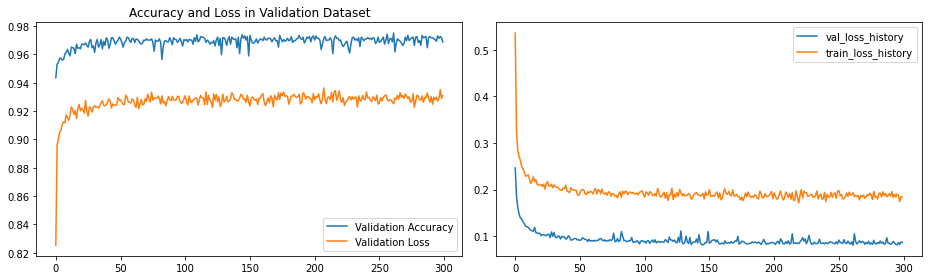


==== END ====
[[791   0   0]
 [  0 777  22]
 [  0  38 781]]

Sensitivity or recall total
0.975093399750934

Sensitivity or recall per classes
[1.         0.97246558 0.95360195]

Precision
[1.         0.95337423 0.97260274]

F1 Score
[1.         0.96282528 0.96300863]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 2

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -72.1886 Acc: 0.3808
val Loss: -141.6593 Acc: 0.3512

Epoch 1/299
----------
train Loss: -219.9899 Acc: 0.3619
val Loss: -288.1188 Acc: 0.3678

Epoch 2/299
----------
train Loss: -367.6837 Acc: 0.3596
val Loss: -412.9668 Acc: 0.3836

Epoch 3/299
----------
train Loss: -515.4854 Acc: 0.3627
val Loss: -564.7690 Acc: 0.3582

Epoch 4/299
----------
train Loss: -663.5135 Acc: 0.3588
val Loss: -713.2064 Acc: 

val Loss: -11287.4155 Acc: 0.3674

Epoch 82/299
----------
train Loss: -12192.0410 Acc: 0.3585
val Loss: -11562.9118 Acc: 0.3491

Epoch 83/299
----------
train Loss: -12336.7655 Acc: 0.3599
val Loss: -12027.4000 Acc: 0.3890

Epoch 84/299
----------
train Loss: -12487.0038 Acc: 0.3605
val Loss: -12165.2969 Acc: 0.3769

Epoch 85/299
----------
train Loss: -12633.8936 Acc: 0.3607
val Loss: -11914.8392 Acc: 0.3690

Epoch 86/299
----------
train Loss: -12784.2452 Acc: 0.3591
val Loss: -12404.0854 Acc: 0.3674

Epoch 87/299
----------
train Loss: -12925.6352 Acc: 0.3598
val Loss: -12638.4888 Acc: 0.3690

Epoch 88/299
----------
train Loss: -13079.9918 Acc: 0.3605
val Loss: -13101.0618 Acc: 0.3744

Epoch 89/299
----------
train Loss: -13212.4903 Acc: 0.3596
val Loss: -12674.7475 Acc: 0.3566

Epoch 90/299
----------
train Loss: -13383.5082 Acc: 0.3582
val Loss: -12798.3877 Acc: 0.4010

Epoch 91/299
----------
train Loss: -13516.6969 Acc: 0.3613
val Loss: -12825.2775 Acc: 0.3748

Epoch 92/299
--

train Loss: -24738.9574 Acc: 0.3602
val Loss: -24547.7364 Acc: 0.3773

Epoch 168/299
----------
train Loss: -24894.2734 Acc: 0.3600
val Loss: -23348.6134 Acc: 0.3719

Epoch 169/299
----------
train Loss: -25054.9152 Acc: 0.3574
val Loss: -23789.2077 Acc: 0.3603

Epoch 170/299
----------
train Loss: -25198.4340 Acc: 0.3588
val Loss: -24200.6186 Acc: 0.4122

Epoch 171/299
----------
train Loss: -25335.1299 Acc: 0.3594
val Loss: -23605.6319 Acc: 0.3719

Epoch 172/299
----------
train Loss: -25488.9123 Acc: 0.3596
val Loss: -24801.8915 Acc: 0.3865

Epoch 173/299
----------
train Loss: -25638.1155 Acc: 0.3583
val Loss: -24212.8379 Acc: 0.3416

Epoch 174/299
----------
train Loss: -25782.6769 Acc: 0.3587
val Loss: -26010.6783 Acc: 0.3433

Epoch 175/299
----------
train Loss: -25938.5122 Acc: 0.3599
val Loss: -24106.0493 Acc: 0.4006

Epoch 176/299
----------
train Loss: -26065.2983 Acc: 0.3587
val Loss: -24301.6244 Acc: 0.4027

Epoch 177/299
----------
train Loss: -26240.4364 Acc: 0.3579
val 

val Loss: -35582.7156 Acc: 0.3885

Epoch 253/299
----------
train Loss: -37459.3601 Acc: 0.3610
val Loss: -35954.3730 Acc: 0.3441

Epoch 254/299
----------
train Loss: -37607.6126 Acc: 0.3577
val Loss: -35043.1402 Acc: 0.3582

Epoch 255/299
----------
train Loss: -37752.1484 Acc: 0.3606
val Loss: -36360.8959 Acc: 0.3686

Epoch 256/299
----------
train Loss: -37898.9126 Acc: 0.3609
val Loss: -36444.9886 Acc: 0.3441

Epoch 257/299
----------
train Loss: -38059.5400 Acc: 0.3593
val Loss: -36841.6737 Acc: 0.3391

Epoch 258/299
----------
train Loss: -38183.0961 Acc: 0.3597
val Loss: -37412.1961 Acc: 0.3624

Epoch 259/299
----------
train Loss: -38337.3626 Acc: 0.3617
val Loss: -36830.4330 Acc: 0.3694

Epoch 260/299
----------
train Loss: -38465.6029 Acc: 0.3594
val Loss: -37667.3126 Acc: 0.3649

Epoch 261/299
----------
train Loss: -38652.8725 Acc: 0.3599
val Loss: -36356.4754 Acc: 0.3375

Epoch 262/299
----------
train Loss: -38786.6720 Acc: 0.3600
val Loss: -39319.1420 Acc: 0.3491

Epoch

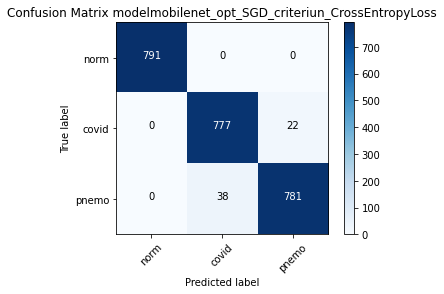

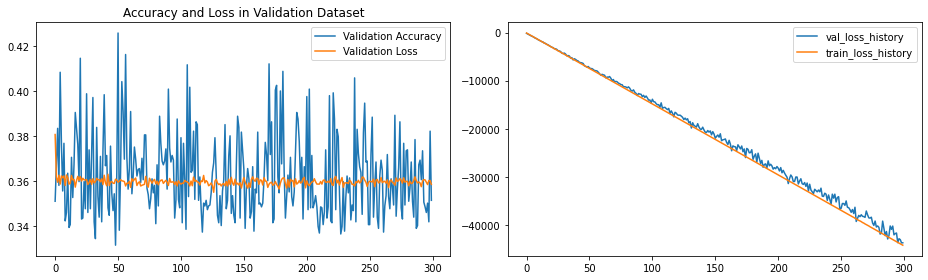


==== END ====
[[791   0   0]
 [564 235   0]
 [813   6   0]]

Sensitivity or recall total
0.4259028642590286

Sensitivity or recall per classes
[1.   0.29 0.  ]

Precision
[0.36 0.98 0.  ]

F1 Score
[0.53 0.45 0.  ]
Confusion matrix, without normalization


/home/jimi/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.5422 Acc: 0.8299
val Loss: 0.2635 Acc: 0.9427

Epoch 1/299
----------
train Loss: 0.3159 Acc: 0.8971
val Loss: 0.1745 Acc: 0.9552

Epoch 2/299
----------
train Loss: 0.2770 Acc: 0.9078
val Loss: 0.1644 Acc: 0.9535

Epoch 3/299
----------
train Loss: 0.2614 Acc: 0.9083
val Loss: 0.1388 Acc: 0.9610

Epoch 4/299
----------
train Loss: 0.2497 Acc: 0.9120
val Loss: 0.1361 Acc: 0.9572

Epoch 5/299
----------
train Loss: 0.2320 Acc: 0.9201
val Loss: 0.1249 Acc: 0.9601

Epoch 6/299
----------
train Loss: 0.2157 Acc: 0.9250
val Loss: 0.1211 Acc: 0.9593

Epoch 7/299
----------
train Loss: 0.2335 Acc: 0.9147
val Loss: 0.1250 Acc: 0.9589

Epoch 8/299
----------
train Loss: 0.2255 Acc: 0.9158
val Loss: 0.1150 Acc: 0.

train Loss: 0.2005 Acc: 0.9257
val Loss: 0.0871 Acc: 0.9685

Epoch 94/299
----------
train Loss: 0.1842 Acc: 0.9303
val Loss: 0.0974 Acc: 0.9651

Epoch 95/299
----------
train Loss: 0.1896 Acc: 0.9264
val Loss: 0.0837 Acc: 0.9722

Epoch 96/299
----------
train Loss: 0.1832 Acc: 0.9291
val Loss: 0.0836 Acc: 0.9722

Epoch 97/299
----------
train Loss: 0.1880 Acc: 0.9282
val Loss: 0.0899 Acc: 0.9685

Epoch 98/299
----------
train Loss: 0.1879 Acc: 0.9285
val Loss: 0.0870 Acc: 0.9693

Epoch 99/299
----------
train Loss: 0.1926 Acc: 0.9272
val Loss: 0.0836 Acc: 0.9697

Epoch 100/299
----------
train Loss: 0.1782 Acc: 0.9311
val Loss: 0.0823 Acc: 0.9701

Epoch 101/299
----------
train Loss: 0.1845 Acc: 0.9282
val Loss: 0.0846 Acc: 0.9718

Epoch 102/299
----------
train Loss: 0.1921 Acc: 0.9261
val Loss: 0.0839 Acc: 0.9689

Epoch 103/299
----------
train Loss: 0.1966 Acc: 0.9258
val Loss: 0.0855 Acc: 0.9701

Epoch 104/299
----------
train Loss: 0.1806 Acc: 0.9304
val Loss: 0.0863 Acc: 0.9685


val Loss: 0.0834 Acc: 0.9701

Epoch 189/299
----------
train Loss: 0.1886 Acc: 0.9296
val Loss: 0.0812 Acc: 0.9714

Epoch 190/299
----------
train Loss: 0.1865 Acc: 0.9283
val Loss: 0.0836 Acc: 0.9718

Epoch 191/299
----------
train Loss: 0.1793 Acc: 0.9313
val Loss: 0.0831 Acc: 0.9701

Epoch 192/299
----------
train Loss: 0.1932 Acc: 0.9260
val Loss: 0.0855 Acc: 0.9693

Epoch 193/299
----------
train Loss: 0.1819 Acc: 0.9292
val Loss: 0.0918 Acc: 0.9639

Epoch 194/299
----------
train Loss: 0.1943 Acc: 0.9263
val Loss: 0.0839 Acc: 0.9705

Epoch 195/299
----------
train Loss: 0.1949 Acc: 0.9261
val Loss: 0.0826 Acc: 0.9726

Epoch 196/299
----------
train Loss: 0.1878 Acc: 0.9274
val Loss: 0.0802 Acc: 0.9734

Epoch 197/299
----------
train Loss: 0.1929 Acc: 0.9283
val Loss: 0.0835 Acc: 0.9705

Epoch 198/299
----------
train Loss: 0.1926 Acc: 0.9249
val Loss: 0.0880 Acc: 0.9676

Epoch 199/299
----------
train Loss: 0.1808 Acc: 0.9324
val Loss: 0.0824 Acc: 0.9718

Epoch 200/299
----------

train Loss: 0.1915 Acc: 0.9269
val Loss: 0.0804 Acc: 0.9705

Epoch 285/299
----------
train Loss: 0.1957 Acc: 0.9266
val Loss: 0.0805 Acc: 0.9722

Epoch 286/299
----------
train Loss: 0.1872 Acc: 0.9295
val Loss: 0.0874 Acc: 0.9697

Epoch 287/299
----------
train Loss: 0.1870 Acc: 0.9293
val Loss: 0.0821 Acc: 0.9718

Epoch 288/299
----------
train Loss: 0.1861 Acc: 0.9281
val Loss: 0.0828 Acc: 0.9709

Epoch 289/299
----------
train Loss: 0.1927 Acc: 0.9290
val Loss: 0.0958 Acc: 0.9668

Epoch 290/299
----------
train Loss: 0.1823 Acc: 0.9294
val Loss: 0.0803 Acc: 0.9730

Epoch 291/299
----------
train Loss: 0.1940 Acc: 0.9250
val Loss: 0.0829 Acc: 0.9709

Epoch 292/299
----------
train Loss: 0.1841 Acc: 0.9316
val Loss: 0.0898 Acc: 0.9672

Epoch 293/299
----------
train Loss: 0.1936 Acc: 0.9267
val Loss: 0.0826 Acc: 0.9705

Epoch 294/299
----------
train Loss: 0.1875 Acc: 0.9289
val Loss: 0.0844 Acc: 0.9709

Epoch 295/299
----------
train Loss: 0.1869 Acc: 0.9293
val Loss: 0.0835 Acc: 0

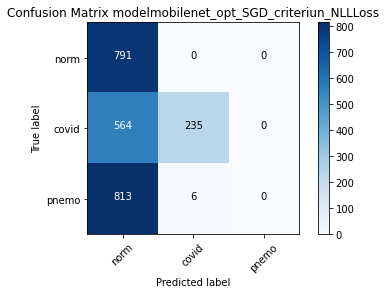

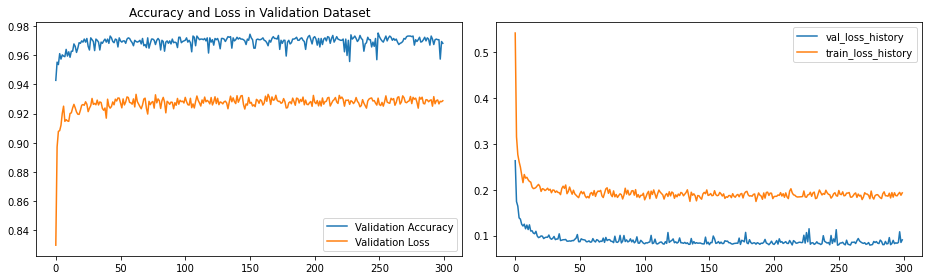


==== END ====
[[791   0   0]
 [  0 771  28]
 [  0  32 787]]

Sensitivity or recall total
0.975093399750934

Sensitivity or recall per classes
[1.   0.96 0.96]

Precision
[1.   0.96 0.97]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 2

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -33.3496 Acc: 0.3839
val Loss: -62.3835 Acc: 0.3284

Epoch 1/299
----------
train Loss: -99.8534 Acc: 0.3432
val Loss: -128.9493 Acc: 0.3292

Epoch 2/299
----------
train Loss: -166.3271 Acc: 0.3433
val Loss: -188.3242 Acc: 0.3508

Epoch 3/299
----------
train Loss: -232.8097 Acc: 0.3626
val Loss: -250.5143 Acc: 0.3753

Epoch 4/299
----------
train Loss: -299.3630 Acc: 0.3683
val Loss: -322.8946 Acc: 0.4064

Epoch 5/299
----------
train Loss: -365.8280 Acc

val Loss: -5279.9889 Acc: 0.5251

Epoch 83/299
----------
train Loss: -5547.9830 Acc: 0.4327
val Loss: -5373.6141 Acc: 0.4753

Epoch 84/299
----------
train Loss: -5615.0246 Acc: 0.4343
val Loss: -5486.1714 Acc: 0.4853

Epoch 85/299
----------
train Loss: -5680.4164 Acc: 0.4295
val Loss: -5464.8168 Acc: 0.5517

Epoch 86/299
----------
train Loss: -5746.0976 Acc: 0.4313
val Loss: -5270.9832 Acc: 0.4832

Epoch 87/299
----------
train Loss: -5813.5985 Acc: 0.4338
val Loss: -5527.2035 Acc: 0.5509

Epoch 88/299
----------
train Loss: -5877.9519 Acc: 0.4287
val Loss: -5624.6569 Acc: 0.4786

Epoch 89/299
----------
train Loss: -5945.4453 Acc: 0.4321
val Loss: -5824.0976 Acc: 0.5467

Epoch 90/299
----------
train Loss: -6012.5903 Acc: 0.4302
val Loss: -5796.5170 Acc: 0.4616

Epoch 91/299
----------
train Loss: -6078.9678 Acc: 0.4374
val Loss: -5852.0374 Acc: 0.5201

Epoch 92/299
----------
train Loss: -6143.1163 Acc: 0.4323
val Loss: -5813.3603 Acc: 0.5189

Epoch 93/299
----------
train Loss: 

val Loss: -11058.1029 Acc: 0.5305

Epoch 170/299
----------
train Loss: -11328.2728 Acc: 0.4494
val Loss: -10913.5660 Acc: 0.5392

Epoch 171/299
----------
train Loss: -11392.4592 Acc: 0.4450
val Loss: -11105.9642 Acc: 0.4961

Epoch 172/299
----------
train Loss: -11457.8620 Acc: 0.4463
val Loss: -11117.8247 Acc: 0.5189

Epoch 173/299
----------
train Loss: -11522.6226 Acc: 0.4453
val Loss: -11238.0508 Acc: 0.4923

Epoch 174/299
----------
train Loss: -11590.6516 Acc: 0.4439
val Loss: -11097.0237 Acc: 0.5102

Epoch 175/299
----------
train Loss: -11655.7359 Acc: 0.4419
val Loss: -11674.0279 Acc: 0.4915

Epoch 176/299
----------
train Loss: -11724.4116 Acc: 0.4430
val Loss: -11200.0616 Acc: 0.5612

Epoch 177/299
----------
train Loss: -11789.5544 Acc: 0.4467
val Loss: -10537.4492 Acc: 0.5484

Epoch 178/299
----------
train Loss: -11854.5264 Acc: 0.4461
val Loss: -11250.7000 Acc: 0.5164

Epoch 179/299
----------
train Loss: -11924.9187 Acc: 0.4440
val Loss: -11498.1262 Acc: 0.5388

Epoch

train Loss: -16968.5909 Acc: 0.4506
val Loss: -15879.1901 Acc: 0.5637

Epoch 256/299
----------
train Loss: -17039.2294 Acc: 0.4467
val Loss: -16387.1649 Acc: 0.5164

Epoch 257/299
----------
train Loss: -17101.6355 Acc: 0.4529
val Loss: -16404.0534 Acc: 0.5425

Epoch 258/299
----------
train Loss: -17162.2783 Acc: 0.4537
val Loss: -16687.6149 Acc: 0.5023

Epoch 259/299
----------
train Loss: -17239.4271 Acc: 0.4466
val Loss: -16402.9918 Acc: 0.4932

Epoch 260/299
----------
train Loss: -17307.1298 Acc: 0.4503
val Loss: -15970.5775 Acc: 0.5330

Epoch 261/299
----------
train Loss: -17367.3557 Acc: 0.4475
val Loss: -16669.2991 Acc: 0.5463

Epoch 262/299
----------
train Loss: -17432.2615 Acc: 0.4509
val Loss: -17073.1555 Acc: 0.4815

Epoch 263/299
----------
train Loss: -17498.9352 Acc: 0.4464
val Loss: -16848.4214 Acc: 0.5330

Epoch 264/299
----------
train Loss: -17564.6753 Acc: 0.4528
val Loss: -17516.5840 Acc: 0.5434

Epoch 265/299
----------
train Loss: -17633.4009 Acc: 0.4481
val 

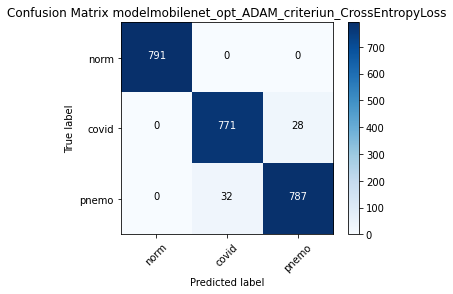

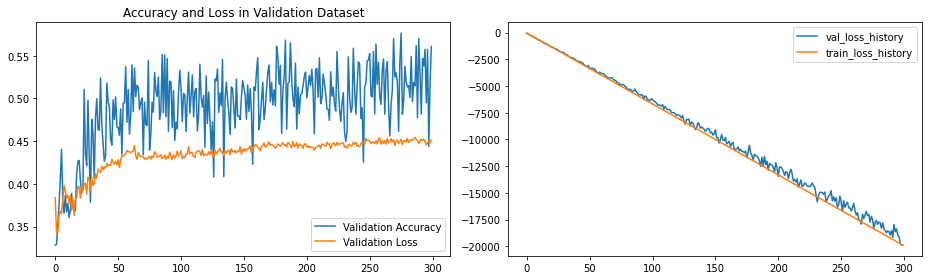


==== END ====
[[791   0   0]
 [201 598   0]
 [722  97   0]]

Sensitivity or recall total
0.5765877957658779

Sensitivity or recall per classes
[1.   0.75 0.  ]

Precision
[0.46 0.86 0.  ]

F1 Score
[0.63 0.8  0.  ]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.4875 Acc: 0.8515
val Loss: 0.2333 Acc: 0.9444

Epoch 1/299
----------
train Loss: 0.3016 Acc: 0.9056
val Loss: 0.1705 Acc: 0.9527

Epoch 2/299
----------
train Loss: 0.2668 Acc: 0.9095
val Loss: 0.1455 Acc: 0.9556

Epoch 3/299
----------
train Loss: 0.2525 Acc: 0.9091
val Loss: 0.1411 Acc: 0.9535

Epoch 4/299
----------
train Loss: 0.2504 Acc: 0.9083
val Loss: 0.1275 Acc: 0.9610

Epoch 5/299
----------
train Loss: 0.2322 Acc: 0.9176
val Loss: 0.1255 Acc

train Loss: 0.1875 Acc: 0.9286
val Loss: 0.0949 Acc: 0.9676

Epoch 91/299
----------
train Loss: 0.1838 Acc: 0.9336
val Loss: 0.0851 Acc: 0.9722

Epoch 92/299
----------
train Loss: 0.1978 Acc: 0.9299
val Loss: 0.0867 Acc: 0.9709

Epoch 93/299
----------
train Loss: 0.1985 Acc: 0.9255
val Loss: 0.0836 Acc: 0.9709

Epoch 94/299
----------
train Loss: 0.1802 Acc: 0.9311
val Loss: 0.0841 Acc: 0.9722

Epoch 95/299
----------
train Loss: 0.1892 Acc: 0.9264
val Loss: 0.0813 Acc: 0.9726

Epoch 96/299
----------
train Loss: 0.1850 Acc: 0.9282
val Loss: 0.0821 Acc: 0.9709

Epoch 97/299
----------
train Loss: 0.1849 Acc: 0.9298
val Loss: 0.1093 Acc: 0.9601

Epoch 98/299
----------
train Loss: 0.1987 Acc: 0.9259
val Loss: 0.0850 Acc: 0.9689

Epoch 99/299
----------
train Loss: 0.2057 Acc: 0.9209
val Loss: 0.0832 Acc: 0.9722

Epoch 100/299
----------
train Loss: 0.1952 Acc: 0.9271
val Loss: 0.0808 Acc: 0.9734

Epoch 101/299
----------
train Loss: 0.1939 Acc: 0.9268
val Loss: 0.0888 Acc: 0.9693

Ep

train Loss: 0.1883 Acc: 0.9267
val Loss: 0.0857 Acc: 0.9693

Epoch 187/299
----------
train Loss: 0.1992 Acc: 0.9246
val Loss: 0.0837 Acc: 0.9709

Epoch 188/299
----------
train Loss: 0.1805 Acc: 0.9292
val Loss: 0.0833 Acc: 0.9726

Epoch 189/299
----------
train Loss: 0.2030 Acc: 0.9238
val Loss: 0.0905 Acc: 0.9664

Epoch 190/299
----------
train Loss: 0.1831 Acc: 0.9283
val Loss: 0.0907 Acc: 0.9664

Epoch 191/299
----------
train Loss: 0.1814 Acc: 0.9306
val Loss: 0.0790 Acc: 0.9709

Epoch 192/299
----------
train Loss: 0.1847 Acc: 0.9301
val Loss: 0.0832 Acc: 0.9709

Epoch 193/299
----------
train Loss: 0.1867 Acc: 0.9263
val Loss: 0.0807 Acc: 0.9722

Epoch 194/299
----------
train Loss: 0.1821 Acc: 0.9285
val Loss: 0.0820 Acc: 0.9726

Epoch 195/299
----------
train Loss: 0.2020 Acc: 0.9225
val Loss: 0.0801 Acc: 0.9709

Epoch 196/299
----------
train Loss: 0.1970 Acc: 0.9223
val Loss: 0.0829 Acc: 0.9705

Epoch 197/299
----------
train Loss: 0.1978 Acc: 0.9233
val Loss: 0.0842 Acc: 0

val Loss: 0.0838 Acc: 0.9697

Epoch 282/299
----------
train Loss: 0.1906 Acc: 0.9277
val Loss: 0.0824 Acc: 0.9701

Epoch 283/299
----------
train Loss: 0.1877 Acc: 0.9292
val Loss: 0.0913 Acc: 0.9660

Epoch 284/299
----------
train Loss: 0.1856 Acc: 0.9284
val Loss: 0.0865 Acc: 0.9701

Epoch 285/299
----------
train Loss: 0.1924 Acc: 0.9270
val Loss: 0.0799 Acc: 0.9714

Epoch 286/299
----------
train Loss: 0.1949 Acc: 0.9252
val Loss: 0.0816 Acc: 0.9718

Epoch 287/299
----------
train Loss: 0.1861 Acc: 0.9304
val Loss: 0.0900 Acc: 0.9680

Epoch 288/299
----------
train Loss: 0.1872 Acc: 0.9276
val Loss: 0.0871 Acc: 0.9701

Epoch 289/299
----------
train Loss: 0.1859 Acc: 0.9309
val Loss: 0.0869 Acc: 0.9689

Epoch 290/299
----------
train Loss: 0.1846 Acc: 0.9279
val Loss: 0.0964 Acc: 0.9651

Epoch 291/299
----------
train Loss: 0.1968 Acc: 0.9266
val Loss: 0.0827 Acc: 0.9718

Epoch 292/299
----------
train Loss: 0.1858 Acc: 0.9302
val Loss: 0.0833 Acc: 0.9718

Epoch 293/299
----------

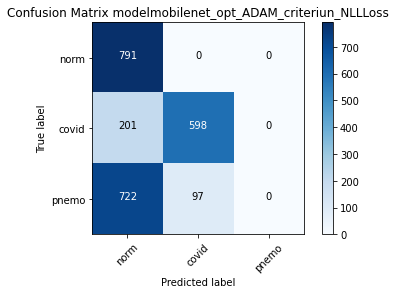

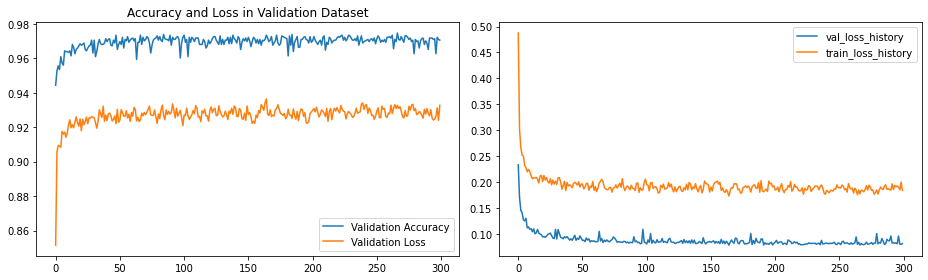


==== END ====
[[791   0   0]
 [  1 774  24]
 [  0  36 783]]

Sensitivity or recall total
0.9746782897467829

Sensitivity or recall per classes
[1.   0.97 0.96]

Precision
[1.   0.96 0.97]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 2

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -39.7596 Acc: 0.3455
val Loss: -67.9620 Acc: 0.4803

Epoch 1/299
----------
train Loss: -106.3667 Acc: 0.5292
val Loss: -133.7687 Acc: 0.6546

Epoch 2/299
----------
train Loss: -172.9476 Acc: 0.6387
val Loss: -191.3969 Acc: 0.6563

Epoch 3/299
----------
train Loss: -239.2657 Acc: 0.6280
val Loss: -256.8847 Acc: 0.6430

Epoch 4/299
----------
train Loss: -305.3574 Acc: 0.6175
val Loss: -327.0900 Acc: 0.6476

Epoch 5/299
----------
train Loss: -371.7908 A

val Loss: -5375.4866 Acc: 0.5073

Epoch 83/299
----------
train Loss: -5546.3213 Acc: 0.4459
val Loss: -5228.0721 Acc: 0.5342

Epoch 84/299
----------
train Loss: -5613.7534 Acc: 0.4498
val Loss: -5368.5689 Acc: 0.4815

Epoch 85/299
----------
train Loss: -5676.9803 Acc: 0.4473
val Loss: -5450.4832 Acc: 0.5172

Epoch 86/299
----------
train Loss: -5744.3828 Acc: 0.4466
val Loss: -5440.1737 Acc: 0.5193

Epoch 87/299
----------
train Loss: -5809.9933 Acc: 0.4451
val Loss: -5517.0486 Acc: 0.5272

Epoch 88/299
----------
train Loss: -5876.2643 Acc: 0.4430
val Loss: -5673.3035 Acc: 0.4944

Epoch 89/299
----------
train Loss: -5943.1832 Acc: 0.4496
val Loss: -5555.5833 Acc: 0.5459

Epoch 90/299
----------
train Loss: -6008.1492 Acc: 0.4515
val Loss: -5740.9903 Acc: 0.5205

Epoch 91/299
----------
train Loss: -6075.4360 Acc: 0.4508
val Loss: -6087.1779 Acc: 0.4795

Epoch 92/299
----------
train Loss: -6142.2052 Acc: 0.4494
val Loss: -5866.9066 Acc: 0.5160

Epoch 93/299
----------
train Loss: 

train Loss: -11319.9748 Acc: 0.4408
val Loss: -10666.5631 Acc: 0.5002

Epoch 171/299
----------
train Loss: -11388.1756 Acc: 0.4468
val Loss: -10910.5196 Acc: 0.5409

Epoch 172/299
----------
train Loss: -11451.4184 Acc: 0.4437
val Loss: -11393.1948 Acc: 0.5006

Epoch 173/299
----------
train Loss: -11518.4770 Acc: 0.4472
val Loss: -10983.3908 Acc: 0.4952

Epoch 174/299
----------
train Loss: -11588.7044 Acc: 0.4420
val Loss: -11023.7775 Acc: 0.4981

Epoch 175/299
----------
train Loss: -11656.9297 Acc: 0.4428
val Loss: -10837.0678 Acc: 0.5409

Epoch 176/299
----------
train Loss: -11720.2577 Acc: 0.4420
val Loss: -11230.6080 Acc: 0.5807

Epoch 177/299
----------
train Loss: -11783.0547 Acc: 0.4446
val Loss: -11403.3955 Acc: 0.4965

Epoch 178/299
----------
train Loss: -11852.0559 Acc: 0.4428
val Loss: -11669.4083 Acc: 0.4525

Epoch 179/299
----------
train Loss: -11916.7042 Acc: 0.4422
val Loss: -11359.0986 Acc: 0.5525

Epoch 180/299
----------
train Loss: -11984.3699 Acc: 0.4455
val 

val Loss: -16097.8424 Acc: 0.4965

Epoch 256/299
----------
train Loss: -17020.4263 Acc: 0.4460
val Loss: -16258.0482 Acc: 0.4919

Epoch 257/299
----------
train Loss: -17093.7476 Acc: 0.4513
val Loss: -16992.4915 Acc: 0.5326

Epoch 258/299
----------
train Loss: -17157.5147 Acc: 0.4465
val Loss: -15981.3749 Acc: 0.5230

Epoch 259/299
----------
train Loss: -17226.5466 Acc: 0.4484
val Loss: -16486.3575 Acc: 0.5185

Epoch 260/299
----------
train Loss: -17286.3311 Acc: 0.4510
val Loss: -16829.7234 Acc: 0.5388

Epoch 261/299
----------
train Loss: -17354.4325 Acc: 0.4500
val Loss: -16648.4858 Acc: 0.5193

Epoch 262/299
----------
train Loss: -17420.8808 Acc: 0.4475
val Loss: -16705.4178 Acc: 0.5056

Epoch 263/299
----------
train Loss: -17490.3850 Acc: 0.4455
val Loss: -17663.8285 Acc: 0.5152

Epoch 264/299
----------
train Loss: -17551.8933 Acc: 0.4528
val Loss: -16804.2109 Acc: 0.5359

Epoch 265/299
----------
train Loss: -17623.5630 Acc: 0.4486
val Loss: -17243.0722 Acc: 0.5401

Epoch

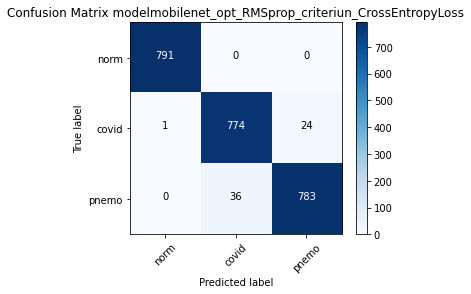

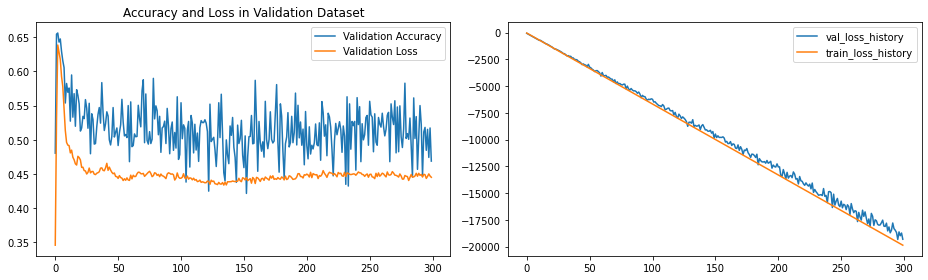


==== END ====
[[790   1   0]
 [  9 790   0]
 [157 661   1]]

Sensitivity or recall total
0.6562889165628891

Sensitivity or recall per classes
[1.   0.99 0.  ]

Precision
[0.83 0.54 1.  ]

F1 Score
[0.9 0.7 0. ]
Confusion matrix, without normalization


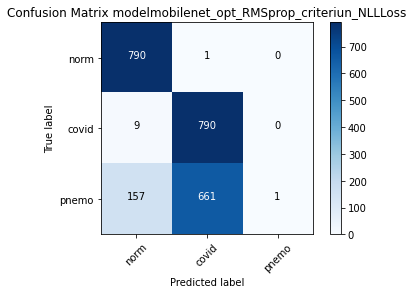

In [22]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['mobilenet'] #['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg', 'googlenet', 'shufflenet', 'mobilenet' ]
lrs = [1e-4]
_epoch = [300]
batch_sizes = [8]
opt = [1, 2, 3]
crt = [1, 2]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                         
                        
                            
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        
                        
                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
                        if _crt == 2:
                            criterion = nn.NLLLoss()
                            crt_name = 'NLLLoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)
                        
                        

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], 
                        title='Confusion Matrix model'+_model+'_opt_'+opt_name+'_criteriun_'+crt_name)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [42]:
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = "/home/jimi/dissertacao/covid19/datasets/80-20/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,3),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,300)

from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/300
----------
train loss:  0.2861  acc: 0.8961
val loss:  0.1513  acc: 0.9481
epoch 2/300
----------
train loss:  0.1862  acc: 0.9335
val loss:  0.1124  acc: 0.9606
epoch 3/300
----------
train loss:  0.1733  acc: 0.9355
val loss:  0.1183  acc: 0.9597
epoch 4/300
----------
train loss:  0.1353  acc: 0.9514
val loss:  0.1139  acc: 0.9589
epoch 5/300
----------
train loss:  0.1371  acc: 0.9514
val loss:  0.1076  acc: 0.9618
epoch 6/300
----------
train loss:  0.1363  acc: 0.9499
val loss:  0.1058  acc: 0.9626
epoch 7/300
----------
train loss:  0.1365  acc: 0.9512
val loss:  0.1081  acc: 0.9606
epoch 8/300
----------


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





In [ ]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [ ]:
data_dir_test = "/home/jimi/dissertacao/covid19/datasets/80-20/test/"

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:
model_ft.eval()

In [ ]:
#print(model)

In [ ]:
#print(model_ft)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/1785.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/860.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/2480.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-10.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 2 FIIMMMM

In [22]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [2]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [12]:
model_ft = GoogLeNet.from_pretrained('googlenet')
# ... image preprocessing as in the classification example ...
inputs = torch.randn(1, 3, 224, 224)
print(inputs.shape) # torch.Size([1, 3, 224, 224])

feature_extract = model_ft.extract_features(inputs)
print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

model_ft.eval()

Loaded pretrained weights for googlenet
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024, 7, 7])


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
model_ft = models.shufflenet_v2_x1_0(pretrained=True)
model_ft.Layers
# # ... image preprocessing as in the classification example ...
# inputs = torch.randn(1, 3, 224, 224)
# print(inputs.shape) # torch.Size([1, 3, 224, 224])

# feature_extract = model_ft.extract_features(inputs)
# print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

# model_ft.eval()

AttributeError: 'ShuffleNetV2' object has no attribute 'Layers'

In [15]:
model_ft = models.shufflenet_v2_x1_0(pretrained=True)
# ... image preprocessing as in the classification example ...
inputs = torch.randn(1, 3, 224, 224)
print(inputs.shape) # torch.Size([1, 3, 224, 224])

feature_extract = model_ft.fc(inputs)
print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

model_ft.eval()

torch.Size([1, 3, 224, 224])


RuntimeError: size mismatch, m1: [672 x 224], m2: [1024 x 1000] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41